<center> <img src = https://deveducation.com/wp-content/uploads/2022/05/e02645f9-693d-40de-a13f-c60cbbdf273e.webp alt="drawing" style="width:400px;">

# <center> PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle

In [42]:
# Импортируем необходимые библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from geopy.geocoders import Nominatim
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 

0. Предварительное знакомство с данными.


In [43]:
df_train = pd.read_csv('Data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('Data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('Data/submission.csv') # самбмишн

In [44]:
display(df_train.info())
display(df_test.info())
display(sample_submission.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


None

In [45]:
display(df_train.head(3))
display(df_test.head(3))
display(sample_submission.head(3))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


In [46]:
#Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\User\AppData\Local\Temp\ipykernel_13648\3925405557.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [47]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [48]:
hotels.isna().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

1. Очистка данных от пропущенных значений.

In [49]:
# Очистка пропусков в координатах на основе использования библиотеки geopy

# Создаем список отелей, для которых пропущены координаты
missing_data = hotels[hotels['lat'].isna() | hotels['lng'].isna()]
missing_list = list(missing_data['hotel_name'].unique())

# Создаем объект геокодера
geolocator = Nominatim(user_agent="geoapiUseragent")

# Словарь для пропущенных значений
hotel_coordinates = {}

for hotel_name in missing_list:
    except_ = True
    i = 4
    while except_:
        try:
            except_ = False
            short_hotel_name = hotel_name.split(' ')[:i]
            short_hotel_name = " ".join(short_hotel_name)
            location = geolocator.geocode(short_hotel_name)
            hotel_coordinates[hotel_name] = [location.latitude, location.longitude]
        except:
            print('Except')
            print(short_hotel_name)
            i -= 1
            except_ = True
        
display(hotel_coordinates)

def get_coord(row):
    if pd.isna(row.lat):
        row.lat = hotel_coordinates[row.hotel_name][0]
        row.lng = hotel_coordinates[row.hotel_name][1]
        return row
    else: 
        return row

hotels = hotels.apply(lambda row: get_coord(row), axis=1)

Except
City Hotel Deutschmeister
Except
City Hotel Deutschmeister
Except
Fleming s Selection Hotel
Except
Mercure Paris Gare Montparnasse
Except
Hotel Pension Baron am
Except
Hotel Pension Baron
Except
Derag Livinghotel Kaiser Franz
Except
Derag Livinghotel Kaiser


{'Hotel Atlanta': [50.8520697, 4.354408380443903],
 'City Hotel Deutschmeister': [41.321954700000006, 19.81620757120013],
 'Holiday Inn Paris Montmartre': [48.8716034, 2.3435792],
 'Fleming s Selection Hotel Wien City': [50.11753335, 8.680225139617644],
 'Hotel City Central': [48.2135658, 16.3799212],
 'Cordial Theaterhotel Wien': [48.20966395, 16.35142625097432],
 'NH Collection Barcelona Podium': [41.39188235, 2.1779639552623635],
 'Hotel Daniel Vienna': [48.1888627, 16.3838516356697],
 'Maison Albar Hotel Paris Op ra Diamond': [48.8753905, 2.2944392],
 'Mercure Paris Gare Montparnasse': [48.8760449, 2.3557305],
 'Hotel Pension Baron am Schottentor': [50.8401575, 11.4023074],
 'Austria Trend Hotel Schloss Wilhelminenberg Wien': [48.2196753, 16.2854959],
 'Renaissance Barcelona Hotel': [41.3927154, 2.1674921],
 'Derag Livinghotel Kaiser Franz Joseph Vienna': [48.1344161, 11.5759387],
 'Roomz Vienna': [48.222974, 16.393313],
 'Hotel Park Villa': [49.13646555, 9.230946491810585],
 'Hote

In [50]:
hotels.isna().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
dtype: int64

2. Создание новых признаков.

In [51]:
# 2.1 Признак город расположения отеля.

def get_city(arg):
    """Функция извлечения названия города из признака адреса отеля

    Args:
        arg (object): Адрес отеля

    Returns:
        string: Город расположения отеля
    """
    city = arg.split(' ')[-2]
    
    if (city == 'United'):
        city = arg.split(' ')[-5]
        return city

    return city
    
hotels['city'] = hotels['hotel_address'].apply(get_city)
display(hotels['city'].value_counts())
hotels = hotels.drop('hotel_address', axis=1)
display(hotels.head(3))

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,city
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Milan
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Amsterdam
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Barcelona


In [52]:
# Задание 2.2 Признак суммарное количество отелей в городе.

table = hotels.groupby(['city'])['hotel_name'].unique()
hotels['total_hotels_counts'] = hotels['city'].apply(lambda x: len(table[x]))
hotels = hotels.drop('hotel_name', axis=1)
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,city,total_hotels_counts
0,904,7/21/2017,8.1,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Milan,162
1,612,12/12/2016,8.6,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Amsterdam,105
2,46,11/26/2015,8.3,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Barcelona,211


In [53]:
#2.3 Признак сезонности на основе даты.

hotels['review_date'] = pd.to_datetime(hotels['review_date'])

def get_season(dt):
    """Функция получения сезона в зависимости от месяца

    Args:
        arg (object): Дата оставления отзыва

    Returns:
        string: Название сезона
    """
    if dt.month in [12, 1, 2]:
        return "Winter"
    elif dt.month in [3, 4, 5]:
        return "Spring"
    elif dt.month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

hotels['season'] = hotels['review_date'].apply(get_season)

hotels = hotels.drop('review_date', axis=1)
display(hotels.head(3))

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,city,total_hotels_counts,season
0,904,8.1,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Milan,162,Summer
1,612,8.6,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Amsterdam,105,Winter
2,46,8.3,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Barcelona,211,Fall


In [54]:
# Задание 2.4 Признак национальность ревьюера.

display(hotels['reviewer_nationality'].value_counts())

hotels['reviewer_nationality_UK'] = hotels['reviewer_nationality'].apply(lambda x: 1 if x.strip() == 'United Kingdom' else 0)
hotels['reviewer_nationality_USA'] = hotels['reviewer_nationality'].apply(lambda x: 1 if x.strip() == 'United States of America' else 0)

hotels = hotels.drop('reviewer_nationality', axis=1)
hotels.head(3)

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

,additional_number_of_scoring,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,city,total_hotels_counts,season,reviewer_nationality_UK,reviewer_nationality_USA
0,904,8.1,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Milan,162,Summer,1,0
1,612,8.6,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Amsterdam,105,Winter,0,0
2,46,8.3,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Barcelona,211,Fall,0,0


In [55]:
# 2.5 Признаки на основе тегов.

def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

hotels['tags'] = hotels['tags'].apply(rev_func)
    
hotels['Leisure trip'] = hotels['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
hotels['Submitted from a mobile device'] = hotels['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)
hotels['Couple'] = hotels['tags'].apply(lambda x: 1 if 'Couple' in x else 0)

hotels = hotels.drop('tags', axis=1)
display(hotels.head(3))

,additional_number_of_scoring,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,...,sample,reviewer_score,city,total_hotels_counts,season,reviewer_nationality_UK,reviewer_nationality_USA,Leisure trip,Submitted from a mobile device,Couple
0,904,8.1,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,13 days,45.533137,...,0,0.0,Milan,162,Summer,1,0,1,0,1
1,612,8.6,No tissue paper box was present at the room,10,5018,No Positive,0,7,234 day,52.385649,...,0,0.0,Amsterdam,105,Winter,0,0,1,0,0
2,46,8.3,Pillows,3,351,Nice welcoming and service,5,15,616 day,41.393192,...,0,0.0,Barcelona,211,Fall,0,0,0,1,0


In [56]:
# 2.6 Преобразование признака количество дней прошедшее с даты ревью

def get_days(arg):
    """Функция преобразования признака количества дней прошедшее с даты ревью

    Args:
        arg (object): Количество дней в текстовом формате

    Returns:
        int: Количество дней
    """

    days = arg.split(' ')[0]

    return int(days)

hotels['days_since_review'] = hotels['days_since_review'].apply(get_days)

display(hotels.head(3))

,additional_number_of_scoring,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,...,sample,reviewer_score,city,total_hotels_counts,season,reviewer_nationality_UK,reviewer_nationality_USA,Leisure trip,Submitted from a mobile device,Couple
0,904,8.1,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,13,45.533137,...,0,0.0,Milan,162,Summer,1,0,1,0,1
1,612,8.6,No tissue paper box was present at the room,10,5018,No Positive,0,7,234,52.385649,...,0,0.0,Amsterdam,105,Winter,0,0,1,0,0
2,46,8.3,Pillows,3,351,Nice welcoming and service,5,15,616,41.393192,...,0,0.0,Barcelona,211,Fall,0,0,0,1,0


3. Кодирование категориальных признаков.

In [57]:
#Кодирование номинальных категориальных признаков. Признаки: название города, сезонность. Используем метод get_dummies().

hotels = pd.get_dummies(hotels, columns=['city', 'season'])

hotels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   negative_review                             515738 non-null  object 
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   positive_review                             515738 non-null  object 
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   days_since_review                           515738 non-null  int64  
 9   lat                                         515738 non-null  float64
 

4. Анализ текстовых отзывов.

In [58]:
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

hotels['negative_review_neg'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['negative_review_compound'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels['positive_review_pos'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['positive_review_compound'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels.info()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   negative_review                             515738 non-null  object 
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   positive_review                             515738 non-null  object 
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   days_since_review                           515738 non-null  int64  
 9   lat                                         515738 non-null  float64
 

In [59]:
hotels = hotels.drop('negative_review', axis=1)
hotels = hotels.drop('positive_review', axis=1)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

5. Анализ мультиколлинеарности.

<AxesSubplot:>

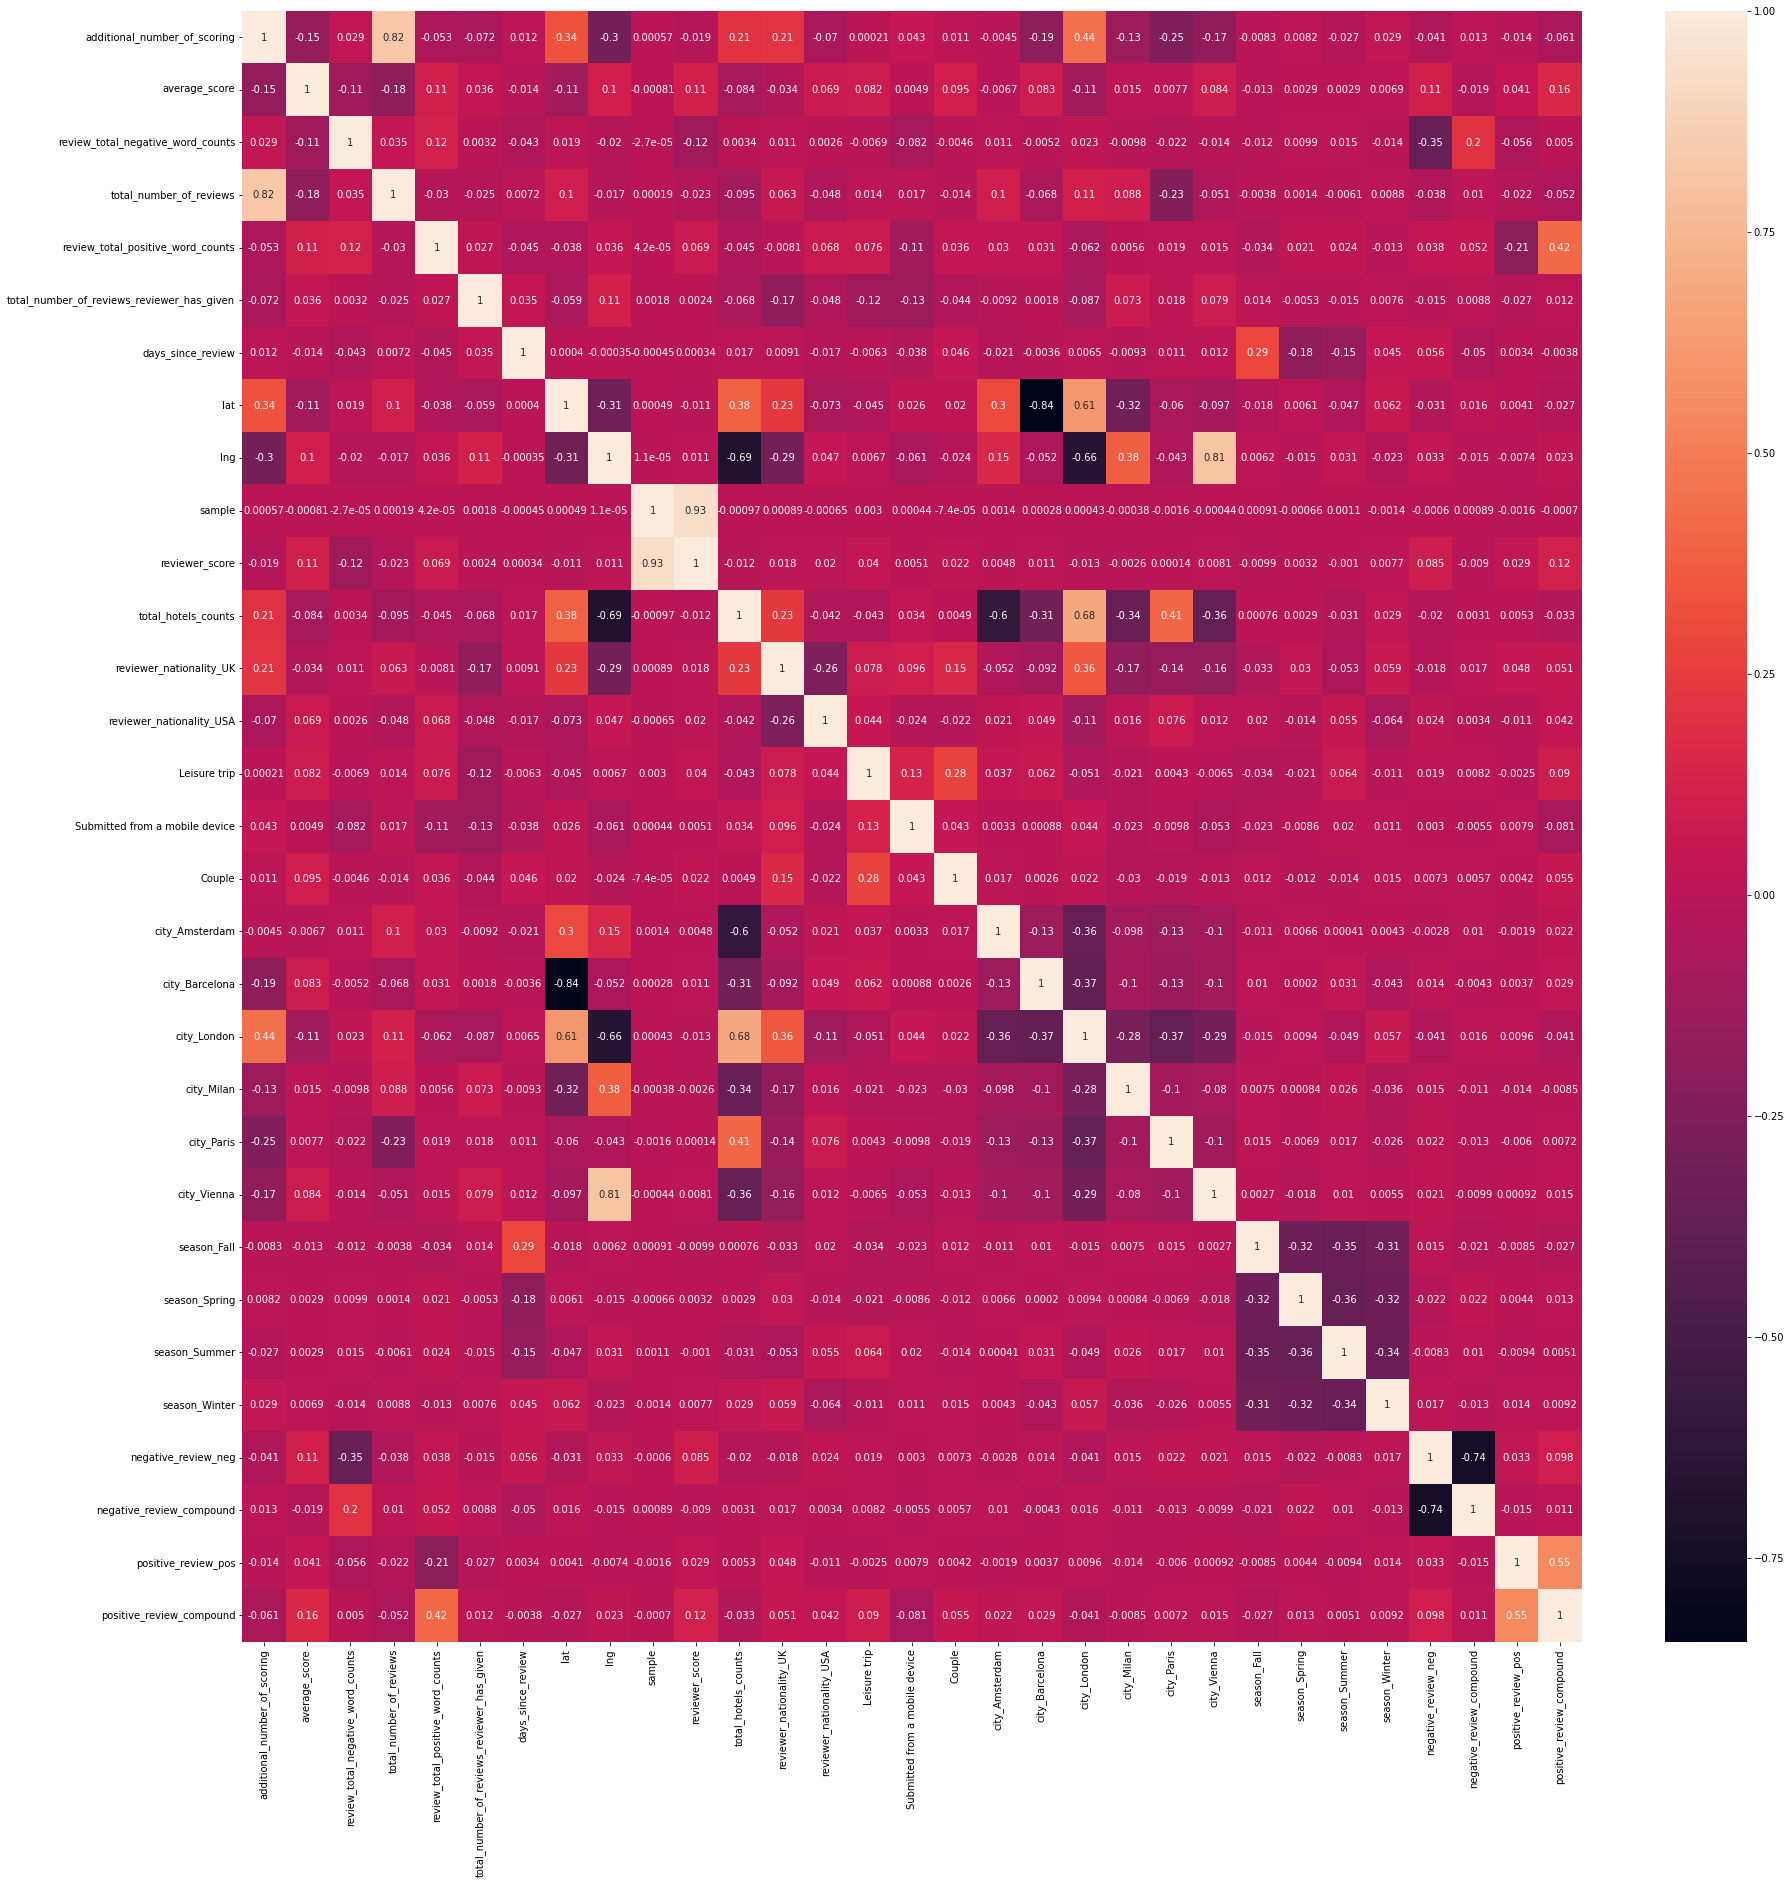

In [60]:
#Анализ мультиколлинеарности числовых признаков. Если признаки имеют коэффициент корреляции >+/- 0.95. то один из признаков удаляем.

fig = plt.figure(figsize=(30,30))
sns.heatmap(hotels.corr(method='pearson'), annot=True)

6. Отбор признаков на основе их важности.

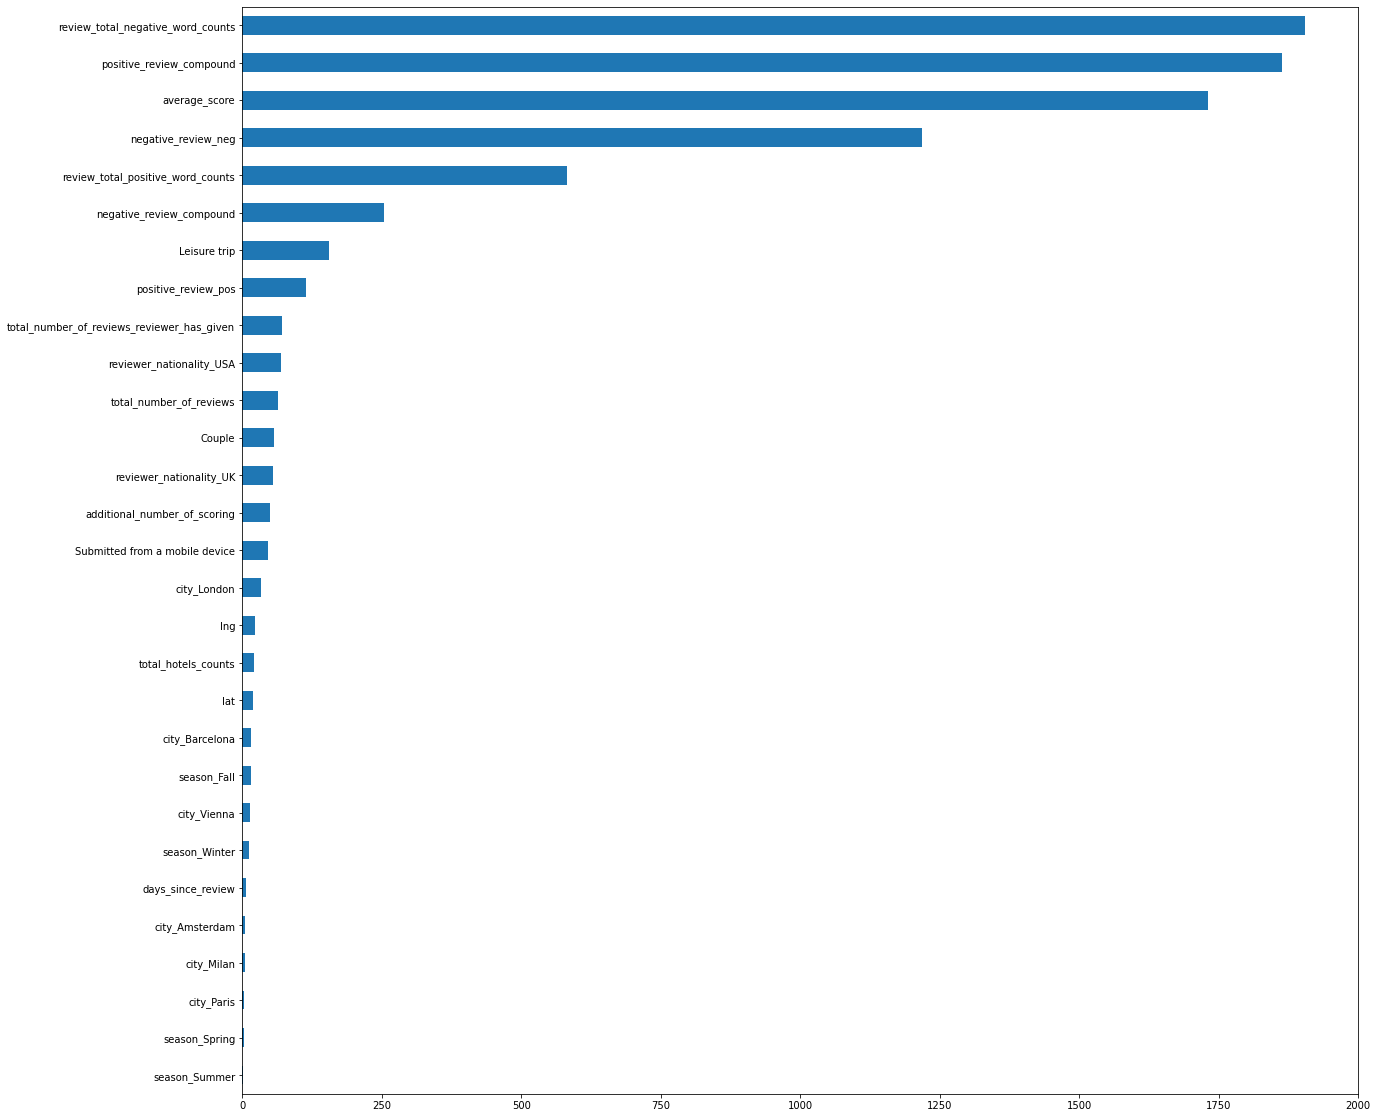

In [61]:
# Проводим тест ANOVA
# Оставляем только 15-20 признаков, которые имеют наибольшее значение.

# Выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

fig = plt.figure(figsize=(20,20))
imp_num = pd.Series(f_classif(X, y)[0], index = X.columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

X = X.drop(columns=['season_Summer', 'season_Spring','city_Paris', 'city_Milan', 'city_Amsterdam', 'days_since_review',
                   'season_Winter', 'city_Vienna', 'city_Barcelona', 'season_Fall'], axis=1)

In [62]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 128935 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   lat                                         386803 non-null  float64
 7   lng                                         386803 non-null  float64
 8   total_hotels_counts                         386803 non-null  int64  
 9   reviewer_nationality_UK                     386803 non-null  int6

7. Нормализация данных.

In [63]:
#7.1 Использование масштабирования данных на основе MinMaxScaler (опционально).
#7.2 Использование стандартизации данных на основе StandardScaler (опционально).

8. Реализация машинного алгоритма и проверка его эффективности. MAPE должен быть менее 13.5%

In [64]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
    # Для тестирования мы будем использовать 20 % от исходного датасета.  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [65]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12583472100358958


In [68]:
test_data = test_data.drop(columns=['reviewer_score','season_Summer', 'season_Spring','city_Paris', 'city_Milan', 'city_Amsterdam', 'days_since_review',
                   'season_Winter', 'city_Vienna', 'city_Barcelona', 'season_Fall'], axis=1)
predict_submission = regr.predict(test_data)
predict_submission

array([8.568 , 7.63  , 8.853 , ..., 8.255 , 9.685 , 7.4985])

In [69]:
list(sample_submission)

['reviewer_score', 'id']

In [70]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.568,488440
1,7.630,274649
2,8.853,374688
3,9.802,404352
4,9.554,451596
5,9.241,302161
6,7.696,317079
7,7.044,13963
8,8.296,159785
9,7.493,195089


# Выводы

В результате работы над данным проектом:
-  Cоздана первая модель, основаннованная на алгоритмах машинного обучения
-  Принято участие в соревновании на Kaggle
-  В результате выполнения правильной подготовки данных точность модели повысилась с 14.1% до 12.5% MAPE.